# Recommendation Engine with PySpark

<font size=3>This recommendation engine uses implicit feedback data from an e-commerce website, which includes user interactions such as views, carts, and purchases. [Dataset Link](https://www.kaggle.com/datasets/mkechinov/ecommerce-behavior-data-from-multi-category-store)

<font size=3>The engine provides personalized recommendations to users by using matrix factorization with the Alternating Least Squares algorithm along with other features such as purchase per view. Additionally, it identifies substitute and supplementary products by comparing their vectors using the Locality Sensitive Hashing algorithm.

<font size=3>By improving the user experience and increasing customer satisfaction and retention, the project aimes to increase sales and profit on the platform. The highly personalized nature of the recommendation scores make this engine a valuable tool for any e-commerce company looking to improve their product recommendations.

## Installations

In [2]:
# Install PySpark
!pip install pyspark py4j

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285387 sha256=e2f721ea8efbe7827fef16b77310fab5fa9e32e007955bd9a17a78caa63f2b43
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark


In [3]:
# Install opendatasets
!pip install opendatasets

## Imports

In [7]:
# imports

import pandas as pd
import numpy as np
import zipfile
import os
import sys
import math
import opendatasets as od
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession
from pyspark.context import SparkContext
from pyspark.sql.functions import *
import pyspark.sql.functions as f
from pyspark.sql.types import DoubleType
import pyarrow

from pyspark.ml.recommendation import ALS, ALSModel
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler, Normalizer, SQLTransformer, BucketedRandomProjectionLSH

## Spark Session Initialization

In [8]:
# Create a SparkSession
spark= SparkSession.builder.appName("test_pyspark").getOrCreate()

In [9]:
# Initialize Spark session

sc = SparkSession.builder.appName("Product_Recommendation") \
.config ("spark.sql.shuffle.partitions", "16") \
.config("spark.driver.maxResultSize","4g") \
.config ("spark.sql.execution.arrow.enabled", "true") \
.config("spark.driver.memory", "4g") \
.config("spark.executor.cores", "4") \
.getOrCreate()

sc.sparkContext.setLogLevel("ERROR")

## Data Upload

In [10]:
# Upload the dataset staright from Kaggle
# 3da2045f5a1bd46da11d9a088ff096e9
od.download(
	"https://www.kaggle.com/datasets/mkechinov/ecommerce-behavior-data-from-multi-category-store/download?datasetVersionNumber=8")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: yasmineali
Your Kaggle Key: ··········


100%|██████████| 4.29G/4.29G [00:41<00:00, 111MB/s]


In [11]:
# Read data from a CSV file into a DataFrame
df = sc.read.option('header', True).csv('/content/ecommerce-behavior-data-from-multi-category-store/2019-Oct.csv')


In [9]:
# Print the schema of the DataFrame
df.printSchema()

root
 |-- event_time: string (nullable = true)
 |-- event_type: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- category_id: string (nullable = true)
 |-- category_code: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- price: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- user_session: string (nullable = true)



In [10]:
# Show the first 5 rows of the DataFrame

df.show(5, truncate=False)

+-----------------------+----------+----------+-------------------+-----------------------------------+--------+-------+---------+------------------------------------+
|event_time             |event_type|product_id|category_id        |category_code                      |brand   |price  |user_id  |user_session                        |
+-----------------------+----------+----------+-------------------+-----------------------------------+--------+-------+---------+------------------------------------+
|2019-10-01 00:00:00 UTC|view      |44600062  |2103807459595387724|null                               |shiseido|35.79  |541312140|72d76fde-8bb3-4e00-8c23-a032dfed738c|
|2019-10-01 00:00:00 UTC|view      |3900821   |2053013552326770905|appliances.environment.water_heater|aqua    |33.20  |554748717|9333dfbd-b87a-4708-9857-6336556b0fcc|
|2019-10-01 00:00:01 UTC|view      |17200506  |2053013559792632471|furniture.living_room.sofa         |null    |543.10 |519107250|566511c2-e2e3-422b-b695-cf8e6e

## Exploratory Data Analysis

In [11]:
# Null values
df.select([count(when(isnull(c), c)).alias(c) for c in df.columns]).show()

+----------+----------+----------+-----------+-------------+-------+-----+-------+------------+
|event_time|event_type|product_id|category_id|category_code|  brand|price|user_id|user_session|
+----------+----------+----------+-----------+-------------+-------+-----+-------+------------+
|         0|         0|         0|          0|     13515609|6113008|    0|      0|           2|
+----------+----------+----------+-----------+-------------+-------+-----+-------+------------+



In [12]:
# Number of events
df.groupBy('event_type').count().show()

+----------+--------+
|event_type|   count|
+----------+--------+
|      cart|  926516|
|  purchase|  742849|
|      view|40779399|
+----------+--------+



<Axes: ylabel='count'>

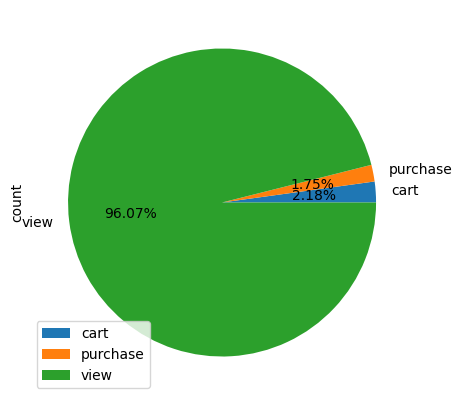

In [12]:
# Plot events distribution
events = df.groupBy('event_type').count().toPandas()
events.plot(kind='pie', y='count', labels=events['event_type'], autopct='%1.2f%%', figsize=(5, 5))

In [ ]:
# Print the number of products in the dataset

df.select(f.countDistinct("product_id")).show()

# 166k products

+--------------------------+
|count(DISTINCT product_id)|
+--------------------------+
|                    166794|
+--------------------------+



<font size=3>Check whether all products belong to a single category by grouping products by their ID, collecting their category IDs into a set, and printing the number of products that belong to a single category.

In [14]:
# Print the number of products that belong to a single category

df.groupby('product_id').agg(f.collect_set('category_id'))\
                        .filter(size(col('collect_set(category_id)')) == 1).count()



166794

In [15]:
# Number of categories in the dataset
df.select(f.countDistinct("category_id")).show()


+---------------------------+
|count(DISTINCT category_id)|
+---------------------------+
|                        624|
+---------------------------+



In [16]:
# Drop duplicates based on the 'category_id' column
# Select and count the unique values in the 'category_code' column
df.drop_duplicates(subset=['category_id']).select(f.count("category_code")).show()


+--------------------+
|count(category_code)|
+--------------------+
|                 252|
+--------------------+



In [17]:
# Select and count the unique values in the 'category_code' column
df.select(f.countDistinct("category_code")).show()


+-----------------------------+
|count(DISTINCT category_code)|
+-----------------------------+
|                          126|
+-----------------------------+



In [18]:
# Print the number of users

df.select(f.countDistinct("user_id")).show()


+-----------------------+
|count(DISTINCT user_id)|
+-----------------------+
|                3022290|
+-----------------------+



In [19]:
# Print the number of unique sessions
df.select(f.countDistinct("user_session")).show()

# 13.8m sessions

+----------------------------+
|count(DISTINCT user_session)|
+----------------------------+
|                     9244421|
+----------------------------+



<Axes: xlabel='date'>

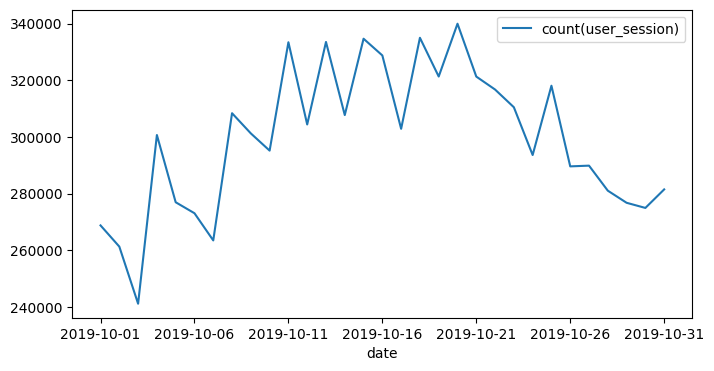

In [20]:
# Plot the daily number of sessions

df = df.withColumn('event_time', to_timestamp('event_time'))
df = df.withColumn('date', date_format("event_time", "yyyy-MM-dd"))

sessions = df.groupby('date').agg(countDistinct('user_session')).toPandas()
sessions.sort_values('date').plot(x='date', figsize=(8, 4))

In [13]:
# Print the number of interactions between users and products, sorted by carts

interactions = df.groupby(['user_id', 'product_id']).agg(sum(when(df['event_type'] == 'view', 1)).alias('views'),
                                                         sum(when(df['event_type'] == 'cart', 1)).alias('carts'),
                                                         sum(when(df['event_type'] == 'purchase', 1)).alias('purchases'))

interactions.sort('carts', ascending=False).show()

+---------+----------+-----+-----+---------+
|  user_id|product_id|views|carts|purchases|
+---------+----------+-----+-----+---------+
|517728689|   1004835|  141|  236|       80|
|538557901|   1004856|    6|  219|        1|
|523974502|   5100563|  311|  216|      248|
|517728689|   1004766|  125|  175|       64|
|541510103|   1004833|  190|  130|      114|
|534769147|   1201247|    8|  118|        1|
|514110288|   5100816|   10|  117|        1|
|513032906|   3601195|    7|  114|     null|
|563571758|   4804295|    1|  113|     null|
|552601624|   1004833|    6|  111|        1|
|520248949|   1005115|    7|  109|        1|
|563771358|   1004833|    6|  108|     null|
|519267944|   1005140|  147|  105|      106|
|548471261|   3601290|    2|  102|        1|
|548760065|   1002547|    7|   97|     null|
|518728454|   2701303|   53|   96|        2|
|535658024|   1002544|  161|   91|       88|
|555130288|   1004665|    2|   90|     null|
|524903918|   2601934|    7|   89|        1|
|549524970

<font size=3>The data reveals a significant number of user-product pairs having a large number of carts, but very few views and purchases.

<font size=3>Further analysis shows that many of these cart events occurred during the same session, which could be due to users repeatedly adding and removing the product.

<font size=3>However, the data does not contain information on remove from cart events, thus we should restrict the number of carts to one per session for each user-product pair.

## Preprocess

In [15]:
def preprocess(df):
    """
    Preprocesses a PySpark DataFrame containing event data.

    Args:
        df (DataFrame): The input DataFrame containing event data.

    Returns:
        DataFrame: A preprocessed DataFrame with the following transformations:
            - Converts 'event_time' column to a timestamp.
            - Converts 'user_id' and 'product_id' columns to integers.
            - Converts 'category_id' column to a long integer.
            - Limits the number of 'cart' events to 1 per session for each user-product pair.
    """

    # Change data types
    df = df.withColumn('event_time', to_timestamp('event_time'))
    df = df.withColumn('user_id', col('user_id').cast('integer'))
    df = df.withColumn('product_id', col('product_id').cast('integer'))
    df = df.withColumn('category_id', col('category_id').cast('long'))

    # Limit the number of carts to 1 per session for each user-product pair
    cart_df = df.filter(col('event_type') == 'cart')
    df = df.filter(col('event_type') != 'cart')
    cart_df = cart_df.dropDuplicates(subset=['product_id', 'user_id', 'user_session'])

    return df

In [16]:
# Apply preprocessing on the DataFrame
df = preprocess(df)

## Feature Engineering

<font size=3>We can extract several features for users, products and categories using the behavioral data:


- Views/carts/purchases: The number of times a user has interacted with a product.


- Distinct products viewed/carted/purchased: The number of unique products a user has viewed, added to their cart, or purchased.


- Average (relative) price viewed/purchased: The average price of products a user has viewed or purchased.


- Interaction rates: These are derived features that provide insights into the behavior of users, such as the purchase per view, cart per view, and purchase per cart rate.

In [17]:
def product_features(df):
    """
    Calculates product-level features and interaction rates from an event DataFrame.

    Args:
        df (DataFrame): The input DataFrame containing event data.

    Returns:
        DataFrame: A DataFrame with product-level features
    """

    # Calculate several metrics for products with the aggregate function
    df = df.groupby('product_id').agg(first('category_id').alias('category_id'),
                                      first('category_code').alias('category_code'),
                                      count(when(df['event_type'] == 'view', True)).alias('views'),
                                      count(when(df['event_type'] == 'cart', True)).alias('carts'),
                                      count(when(df['event_type'] == 'purchase', True)).alias('purchases'),
                                      mean('price').alias('price'),
                                      min('event_time').alias('first_date'),
                                      max('event_time').alias('last_date'))

    # Calculate interaction rates
    df = df.withColumn('purchase_per_view', df['purchases'] / df['views'])
    df = df.withColumn('cart_per_view', df['carts'] / df['views'])
    df = df.withColumn('purchase_per_cart', when(df['carts'] == 0, df['purchases']).otherwise(df['purchases'] / df['carts']))

    return df

In [18]:
def category_features(df):
    """
    Calculates category-level features and interaction rates from an event DataFrame.

    Args:
        df (DataFrame): The input DataFrame containing event data.

    Returns:
        DataFrame: A DataFrame with category-level features

    """
    # Calculate the average product price for each category
    products = df.dropDuplicates(subset=['product_id'])
    products = products.groupby('category_id').agg(avg('price').alias('average_price'))

    # Calculate several metrics for categories with the aggregate function
    df = df.groupby('category_id').agg(first('category_code').alias('category_code'),
                                       countDistinct('product_id').alias('number_of_products'),
                                       count(when(df['event_type'] == 'view', True)).alias('views'),
                                       count(when(df['event_type'] == 'cart', True)).alias('carts'),
                                       count(when(df['event_type'] == 'purchase', True)).alias('purchases'))

    # Calculate interaction rates
    df = df.withColumn('purchase_per_view', df['purchases'] / df['views'])
    df = df.withColumn('cart_per_view', df['carts'] / df['views'])
    df = df.withColumn('purchase_per_cart', when(df['carts'] == 0, df['purchases']).otherwise(df['purchases'] / df['carts']))

    df = df.join(products, on='category_id')

    return df

In [19]:
def user_features(df):
    """
    Calculates user-level features and interaction rates from an event DataFrame.

    Args:
    df (DataFrame): The input DataFrame containing event data.

    Returns:
    DataFrame: A DataFrame with user-level features
    """
    # Calculate several metrics for users with the aggregate function
    df = df.groupby('user_id').agg(count(when(df['event_type'] == 'view', True)).alias('views'),
                                   count(when(df['event_type'] == 'cart', True)).alias('carts'),
                                   count(when(df['event_type'] == 'purchase', True)).alias('purchases'),
                                   countDistinct(when(df['event_type'] == 'view', col('product_id'))).alias('distinct_products_viewed'),
                                   countDistinct(when(df['event_type'] == 'cart', col('product_id'))).alias('distinct_products_carted'),
                                   countDistinct(when(df['event_type'] == 'purchase', col('product_id'))).alias('distinct_products_purchased'),
                                   mean(when(df['event_type'] == 'view', col('price'))).alias('average_price_viewed'),
                                   mean(when(df['event_type'] == 'purchase', col('price'))).alias('average_price_purchased'),
                                   mean(when(df['event_type'] == 'view', col('relative_price'))).alias('avg_relative_price_viewed'),
                                   mean(when(df['event_type'] == 'purchase', col('relative_price'))).alias('avg_relative_price_purchased'),
                                   min('event_time').alias('first_date'),
                                   max('event_time').alias('last_date'))

    # Calculate interaction rates
    df = df.withColumn('purchase_per_view', when(df['views'] == 0, df['purchases']).otherwise(df['purchases'] / df['views']))
    df = df.withColumn('cart_per_view', when(df['views'] == 0, df['carts']).otherwise(df['carts'] / df['views']))
    df = df.withColumn('purchase_per_cart', when(df['carts'] == 0, df['purchases']).otherwise(df['purchases'] / df['carts']))

    return df

<font size=3>Some products and categories have very few interactions, this makes their interaction rates unreliable. For example, a product that has been viewed only 2 times and purchased 1 time would have a purchase per view rate of 0.5, which is very high. Therefore, it's important to apply smoothing to avoid overfitting on small sample sizes.

<font size=3>The smoothing works by taking a weighted average of the product's rate and the category's rate. The weight given to the product's rate depends on the number of interactions, with more weight given to the product's rate as the number of interactions increases. The same smoothing is applied to categories as well, using the overall average interaction rates.

In [20]:
def category_smoothener(categories, mean, attr, rate, min_sample_size=1000):
    """
    Calculate smoothed rates for categories with a small sample size using means of all products
    to combat overfitting.

    Args:
        categories (DataFrame): The input DataFrame containing category-level data.
        mean (float): The overall mean value of the attribute to be smoothed.
        attr (str): The name of the attribute to be smoothed.
        rate (str): The name of the rate column to be calculated and smoothed.
        min_sample_size (int, optional): The minimum sample size for a category to apply smoothing.
            Default is 1000.

    Returns:
        DataFrame: A DataFrame with smoothed rates for categories that meet the minimum sample size
            requirement and unmodified rates for other categories.

    """

    # Weighted average of category value and overall mean
    categories = categories.withColumn(rate, when(categories[attr] < min_sample_size, ((categories[rate] * categories[attr]) + (mean * (min_sample_size - categories[attr]))) / min_sample_size).otherwise(categories[rate]))

    return categories

In [21]:
def product_smoothener(products, categories, attr, rate, min_sample_size=1000):
    """
    Calculate smoothed rates for products with a small sample size using category means
    to combat overfitting.

    Args:
        products (DataFrame): The input DataFrame containing product-level data.
        categories (DataFrame): The DataFrame containing category-level data with means.
        attr (str): The name of the attribute to be smoothed at the product level.
        rate (str): The name of the rate column to be calculated and smoothed at the product level.
        min_sample_size (int, optional): The minimum sample size for a product to apply smoothing.
            Default is 1000.

    Returns:
        DataFrame: A DataFrame with smoothed rates for products that meet the minimum sample size
            requirement and unmodified rates for other products.
    """
    category_rate = rate + '_cat'
    categories = categories.withColumnRenamed(rate, category_rate)
    products = products.join(categories['category_id', category_rate], on='category_id')

    # Weighted average of product value and category value
    products = products.withColumn(rate, when(products[attr] < min_sample_size, ((products[rate] * products[attr]) + (products[category_rate] * (min_sample_size - products[attr]))) / min_sample_size).otherwise(products[rate]))

    products = products.drop(category_rate)
    return products

<font size=3>We must calculate the relative price of each product with respect to its category by scaling its price based on the median and Inter Quartile Range of the category's prices. The median is used as a measure of central tendency and the IQR as a measure of variability.

<font size=3>This scaling accounts for differences in price ranges across categories, enabling us to compare product prices across categories more accurately and without bias. Relative prices will be used to determine if users have a tendency to interact with cheaper or more expensive products.

In [22]:
def calculate_relative_price(products):
    """
    Calculate the relative price of each product in relation to its category using the formula: (price - median) / IQR.

    Args:
        products (DataFrame): The input DataFrame containing product-level data with 'product_id', 'category_id', and 'price' columns.

    Returns:
        DataFrame: A DataFrame with 'product_id' and 'relative_price' columns, representing the calculated relative prices for each product.
    """

    categories = products.groupby('category_id').agg(percentile_approx('price', 0.25, 1000).alias('Q1'),
                                                     percentile_approx('price', 0.5, 1000).alias('median'),
                                                     percentile_approx('price', 0.75, 1000).alias('Q3'))
    # Interquartile range
    categories = categories.withColumn('IQR', col('Q3') - col('Q1'))
    categories = categories.withColumn('IQR', when(col('IQR') < 1, 1).otherwise(col('IQR')))

    # Calculate relative price
    products = products.join(categories, on='category_id')
    products = products.withColumn('relative_price', (col('price') - col('median')) / col('IQR'))

    # In order to avoid extreme values, set the max possible value to 5
    products = products.withColumn('relative_price', when(col('relative_price') > 5, 5).otherwise(col('relative_price')))

    # Set the min possible value to -5
    products = products.withColumn('relative_price', when(col('relative_price') < -5, -5).otherwise(col('relative_price')))

    products = products.select('product_id', 'relative_price')
    return products

In [23]:
# Extract product and category features

products = product_features(df)
categories = category_features(df)

In [24]:
# Calculate relative prices and append it to the main dataframe and product features

relative_prices = calculate_relative_price(products)

df = df.join(relative_prices, on='product_id')
products = products.join(relative_prices, on='product_id')

In [25]:
# Calculate the average interaction rates for all products to smooth category features with low interaction

avg_purchase_per_view = events[events['event_type'] == 'purchase']['count'].values[0] / events[events['event_type'] == 'view']['count'].values[0]
avg_cart_per_view = events[events['event_type'] == 'cart']['count'].values[0] / events[events['event_type'] == 'view']['count'].values[0]
avg_purchase_per_cart = events[events['event_type'] == 'purchase']['count'].values[0] / events[events['event_type'] == 'cart']['count'].values[0]

categories = category_smoothener(categories, avg_purchase_per_view, 'views', 'purchase_per_view', 2000)
categories = category_smoothener(categories, avg_cart_per_view, 'views', 'cart_per_view', 2000)
categories = category_smoothener(categories, avg_purchase_per_cart, 'carts', 'purchase_per_cart', 200)

In [26]:
# Smooth product features with low interaction using corresponding category features

products = product_smoothener(products, categories, 'views', 'purchase_per_view', 1000)
products = product_smoothener(products, categories, 'views', 'cart_per_view', 1000)
products = product_smoothener(products, categories, 'carts', 'purchase_per_cart', 100)

In [27]:
# Extract user features

users = user_features(df)

In [28]:
# Top 50 products in terms of purchases

products.sort('purchases', ascending=False).toPandas().head(50)

,category_id,product_id,category_code,views,carts,purchases,price,first_date,last_date,purchase_per_view,cart_per_view,purchase_per_cart,relative_price
0,2053013555631882655,1004856,electronics.smartphone,419287,0,28944,131.229998,2019-10-01 00:01:06,2019-10-31 23:55:44,0.069031,0.0,0.801766,-0.232907
1,2053013555631882655,1004767,electronics.smartphone,378777,0,21806,248.976746,2019-10-01 00:00:36,2019-10-31 23:59:29,0.057569,0.0,0.801766,0.089843
2,2053013555631882655,1004833,electronics.smartphone,203018,0,12697,172.025075,2019-10-01 00:06:52,2019-10-31 23:56:47,0.062541,0.0,0.801766,-0.121085
3,2053013555631882655,1005115,electronics.smartphone,327715,0,12543,989.242290,2019-10-01 00:01:30,2019-10-31 23:59:13,0.038274,0.0,0.801766,2.118943
4,2053013554658804075,4804056,electronics.audio.headphone,179092,0,12381,160.727972,2019-10-01 00:08:53,2019-10-31 23:59:44,0.069132,0.0,0.801766,1.721477
5,2053013555631882655,1004870,electronics.smartphone,190435,0,10615,285.039358,2019-10-01 00:01:04,2019-10-31 23:59:58,0.055741,0.0,0.801766,0.188692
6,2053013555631882655,1002544,electronics.smartphone,179249,0,10549,460.298345,2019-10-01 00:00:44,2019-10-31 23:57:50,0.058851,0.0,0.801766,0.669084
7,2053013555631882655,1004249,electronics.smartphone,207422,0,9090,739.940657,2019-10-01 00:02:02,2019-10-31 23:49:46,0.043824,0.0,0.801766,1.435596
8,2053013555631882655,1004836,electronics.smartphone,143985,0,7691,229.164276,2019-10-01 00:01:11,2019-10-31 23:41:21,0.053415,0.0,0.801766,0.035536
9,2053013555631882655,1005105,electronics.smartphone,197930,0,7293,1405.587178,2019-10-01 00:00:50,2019-10-31 23:53:59,0.036846,0.0,0.801766,3.260163


## Collaborative Filtering

<font size=3>Collaborative filtering is a technique used in recommendation systems to provide personalized recommendations to users based on their past interactions with items as well as the interactions of similar users. The interaction matrix contains information about which users have interacted with which items, and to what degree.
    
<font size=3>Alternating Least Squares algorithm is one approach to collaborative filtering that can be used to train a model on this interaction matrix. The model learns latent factors for both users and items, which can then be used to make personalized recommendations and to find similar products.
    
<font size=3>We should apply a weighting function to interactions based on recency. This is because recent interactions are often more indicative of a user's current preferences than older interactions. We can use a half-life decay function, where the weight given to an interaction decreases by half after a certain time interval (20 days). By weighting more recent interactions more heavily, the algorithm can provide more relevant recommendations to users.

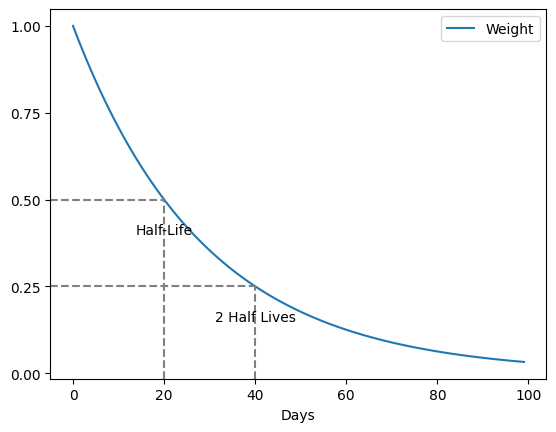

In [30]:
# Plot the half-life decay function

half_life = 20
x = np.arange(0, 100)
y = np.power(0.5, x / half_life)
df1 = pd.DataFrame({'Days': x, 'Weight': y})

# Plot the function
ax = df1.plot(x='Days', y='Weight')

# Add vertical lines at 20 and 40 days with explanatory text
ax.set_yticks([0, 0.25, 0.5, 0.75, 1])
ax.axvline(x=20, linestyle='--', color='gray', ymax=0.49)
ax.axvline(x=40, linestyle='--', color='gray', ymax=0.25)
ax.axhline(y=0.5, linestyle='--', color='gray', xmax=0.23)
ax.axhline(y=0.25, linestyle='--', color='gray', xmax=0.41)
ax.text(20, 0.4, 'Half-Life', ha='center')
ax.text(40, 0.15, '2 Half Lives', ha='center')

plt.show()

In [ ]:
# Get the timestamp of the most recent event in the df
last_date = df.agg(max('event_time')).collect()[0][0]
df = df.withColumn('last_date', lit(last_date))

# Calculate the recency of each event in terms of days
df = df.withColumn('recency', (col('last_date').cast('double') - col('event_time').cast('double')) / 86400)
df = df.drop('last_date')

# Half-life decay function, the value of an event is halved after 20 days
df = df.withColumn('recency_coef', expr('exp(ln(0.5)*recency/20)'))

In [ ]:
# Find the number of views, carts and purchases for each user-product pair
interactions = df.groupby(['user_id', 'product_id']).agg(sum(when(df['event_type'] == 'view', 1) * df['recency_coef']).alias('views'),
                                                         sum(when(df['event_type'] == 'cart', 1) * df['recency_coef']).alias('carts'),
                                                         sum(when(df['event_type'] == 'purchase', 1) * df['recency_coef']).alias('purchases'))
interactions = interactions.na.fill(0)

<font size=3>The interaction matrix is calculated by assigning weights to each type of user interaction. These weighted interactions are then summed to get the total interaction score, which has been subject to a half-life decay function to give more weight to recent interactions. Finally, the values are transformed by taking the logarithm with base 10 and capping the maximum value at 100 to ensure scalability and consistency, while reducing the effect of outliers. The resulting matrix provides a measure of strength of the relationship between users and products.

In [ ]:
def calculate_interaction_matrix(df, view_weight=0.1, cart_weight=0.3, purchase_weight=1.0):
    """
    Calculate an interaction matrix for each row in a DataFrame using weighted interactions with log transformation.

    Args:
        df (DataFrame): The input DataFrame containing interaction data with 'views', 'carts', and 'purchases' columns.
        view_weight (float, optional): Weight for 'views' in the interaction calculation. Default is 0.1.
        cart_weight (float, optional): Weight for 'carts' in the interaction calculation. Default is 0.3.
        purchase_weight (float, optional): Weight for 'purchases' in the interaction calculation. Default is 1.0.

    Returns:
        DataFrame: A DataFrame with an 'interaction' column representing the calculated interaction matrix.
    """
    # Create a new column with the weighted interaction value
    df = df.withColumn('interaction', view_weight * col('views') + cart_weight * col('carts') + purchase_weight * col('purchases'))

    # Use log10 value for views, carts and purchases
    df = df.withColumn('interaction', log10(col('interaction') + 1))

    # Set the max possible value to 100 (log100 = 2)
    df = df.withColumn('interaction', when(col('interaction') > 2, 2).otherwise(col('interaction')))

    return df

In [ ]:
# Calculate the interaction matrix using the calculated interactions DataFrame
interaction_matrix = calculate_interaction_matrix(interactions)

In [ ]:
#  User-product pairs with the highest interaction scores

interaction_matrix.sort('interaction', ascending=False).show()

+---------+----------+------------------+------------------+------------------+------------------+
|  user_id|product_id|             views|             carts|         purchases|       interaction|
+---------+----------+------------------+------------------+------------------+------------------+
|523974502|   5100563|131.13497590049568|13.058701464943132|105.34957866365544|               2.0|
|519267944|   1005140| 89.33544944526338| 47.74061941315046| 64.86371443286258|1.9499724742081415|
|541510103|   1004833|108.62847530196767| 34.49871070283889| 65.41703829551727|1.9426503289101809|
|551361102|   1002528|121.81649949568884|33.090571140337296| 53.88312224793846|1.8864452828432996|
|535658024|   1002544| 95.23731779270915| 39.40008783250292| 53.71816327201135| 1.881167291931816|
|519322381|   2201036|121.20362616586873|25.797064500849302| 49.85953803956353|1.8495362337816084|
|512386086|   1801555| 97.17333358045822|1.9331939994819778|  57.9950164001082|1.8406850268656711|
|515384420

<font size=3>After creating an interaction matrix that quantifies user-product interactions using weights, we can feed this matrix into the ALS algorithm. This algorithm uses the matrix to learn the latent factors of both users and products, which can then be used to make personalized recommendations for users.
    
<font size=3>To optimize the performance of the ALS algorithm, we can use a cross-validation pipeline, which allows us to test and fine-tune different sets of parameters to find the best configuration for our recommendation system. Ultimately, the goal is to create a model that can make accurate and relevant product recommendations to users based on their previous interactions with the system.

In [ ]:
def cross_validate_als(interaction_matrix):
    """
    Perform cross-validation for an ALS recommendation model with hyperparameter tuning.

    Args:
        interaction_matrix (DataFrame): The input DataFrame containing user-product interaction data.

    Returns:
        CrossValidatorModel: The trained ALS model after cross-validation.
    """
    # Define the ALS model
    als = ALS(userCol='user_id', itemCol='product_id', ratingCol='interaction',
              nonnegative=True, coldStartStrategy='drop', implicitPrefs=True)

    # Define the parameter grid for hyperparameter tuning
    param_grid = ParamGridBuilder().addGrid(als.rank, [5, 10, 15, 20]).addGrid(als.regParam, [0.005, 0.01, 0.05, 0.1]).addGrid(als.alpha, [0, 1.0, 5.0]).build()

    # Define the evaluator for computing the evaluation metrics
    evaluator = RegressionEvaluator(metricName='rmse', labelCol='interaction', predictionCol='prediction')

    # Define the cross-validator for performing 5-fold cross-validation
    cv = CrossValidator(estimator=als, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=5, collectSubModels=False)

    # Define the pipeline for fitting the model and evaluating it
    pipeline = Pipeline(stages=[cv])

    # Fit the pipeline on the data and evaluate the model
    model = pipeline.fit(interaction_matrix)

    return model

In [ ]:
model = cross_validate_als(interaction_matrix)

# Model with the lowest RMSE value
bestModel = model.stages[0].bestModel

# Make predictions
predictions = bestModel.transform(interaction_matrix)

# Calculate RMSE and MAE metrics
evaluator = RegressionEvaluator(metricName='rmse', labelCol='interaction', predictionCol='prediction')
rmse = evaluator.setMetricName('rmse').evaluate(predictions)
mae = evaluator.setMetricName('mae').evaluate(predictions)
print(' rmse:' + str(rmse) + ' mae:' + str(mae))

# Print the parameters of the model with the lowest RMSE value
regParam = bestModel._java_obj.parent().getRegParam()
rank = bestModel._java_obj.parent().getRank()
alpha = bestModel._java_obj.parent().getAlpha()
print('rank:' + str(rank) + ' regParam:' + str(regParam) + ' alpha:' + str(alpha))

 rmse:0.18217298055245196 mae:0.07274429779932812
rank:10 regParam:0.1 alpha:0.0


<font size=3>After identifying the best set of parameters, we can build an ALS model directly, instead of running the cross-validation function repeatedly. This approach saves time and resources, making it more efficient to generate product recommendations.

In [ ]:
def simple_als(interaction_matrix):
    """
    Train a simple ALS (Alternating Least Squares) recommendation model and evaluate it.

    Args:
        interaction_matrix (DataFrame): The input DataFrame containing user-product interaction data.

    Returns:
        ALSModel: The trained ALS model.
    """
    # Train-test split
    (train, test) = interaction_matrix.randomSplit([0.8, 0.2])

    # Initialize the model with the optimized parameters
    als = ALS(userCol='user_id', itemCol='product_id', ratingCol='interaction',
              alpha=0.0, regParam=0.1, rank=10, implicitPrefs=True,
              nonnegative=True, coldStartStrategy='drop')

    # Fit the ALS model on the ratings data
    model = als.fit(train)

    # Make predictions
    predictions = model.transform(test)

    # Calculate the RMSE and MAE metrics
    evaluator = RegressionEvaluator(metricName='rmse', labelCol='interaction', predictionCol='prediction')
    rmse = evaluator.evaluate(predictions)
    mae = evaluator.setMetricName('mae').evaluate(predictions)
    print('test rmse:' + str(rmse) + ' mae:' + str(mae))

    return model

In [ ]:
als_model = simple_als(interaction_matrix)

test rmse:0.08024433596353822 mae:0.048873079536562


In [ ]:
# Save model

# Specify the path to your model directory
model_directory = "/content/als_model"

# Specify the name of the zip file you want to create
zip_file_name = "/content/als_model.zip"

# Create a ZipFile object in write mode
with zipfile.ZipFile(zip_file_name, 'w', zipfile.ZIP_DEFLATED) as zipf:
    # Walk through the model directory and add all files to the zip archive
    for foldername, subfolders, filenames in os.walk(model_directory):
        for filename in filenames:
            file_path = os.path.join(foldername, filename)
            # 'arcname' parameter specifies how the files will be stored in the zip
            zipf.write(file_path, os.path.relpath(file_path, model_directory))

## Recommend Products for Users

In [ ]:
# Upload and Extract model

# Specify the name of the zip file you want to extract
zip_file_name = "/content/als_model.zip"

# Specify the directory where you want to extract the model
extracted_directory = "/content/extracted_model_directory"

# Create the directory if it doesn't exist
if not os.path.exists(extracted_directory):
    os.makedirs(extracted_directory)

# Extract the zip file to the specified directory
with zipfile.ZipFile(zip_file_name, 'r') as zipf:
    zipf.extractall(extracted_directory)

In [ ]:
# Load the saved ALS model
als_model = ALSModel.load('/content/extracted_model_directory')

In [ ]:
# 3 random users
user_subset = [523974502, 535658024, 515384420]

# Recommend top 500 products for the users
recommendations = sc.createDataFrame([(user, 0) for user in user_subset], ['user_id', 'product_id'])
recommendations = als_model.recommendForUserSubset(recommendations, 500)

# Show the results
recommendations.show()

+---------+--------------------+
|  user_id|     recommendations|
+---------+--------------------+
|535658024|[{1004249, 0.4520...|
|515384420|[{1005115, 0.3552...|
|523974502|[{1005115, 0.5405...|
+---------+--------------------+



In [ ]:
# Select user 564068124
recs_for_user_1 = sc.createDataFrame(recommendations.collect()[1][1])

In [ ]:
# Products with the highest number of interactions for the user
interactions.filter(col('user_id') == 515384420).sort('purchases', ascending=False).show()

+---------+----------+-------------------+------------------+------------------+
|  user_id|product_id|              views|             carts|         purchases|
+---------+----------+-------------------+------------------+------------------+
|515384420|   1005144|  87.12426504675821| 21.86955883132729| 51.74241658483136|
|515384420|   1005135|  48.47404512517352|13.207115430863432| 25.15419360808046|
|515384420|   1005141|  2.916726846020028|1.1747653544068841|1.1747759523267667|
|515384420|   1005125| 1.6690845315288994|0.5563520629342843| 1.112722425821518|
|515384420|   1005124| 0.5489001888324904|0.5489008493686836|0.5489182437745053|
|515384420|   1005143| 1.3553446697400622|               0.0|               0.0|
|515384420|   5301323| 1.6559299398813723|               0.0|               0.0|
|515384420|   1005138| 0.5887494427962341|               0.0|               0.0|
|515384420|   1005142| 0.5473639547510685|               0.0|               0.0|
|515384420|   5300278|   0.4

<font size=3>When generating recommendations, we can enhance the collaborative filtering (CF) scores by incorporating additional features that result in more engaging and personalized recommendations. With this function, we combine the CF scores with two other features: the conversion rate of the product and the spending habits of the user.

<font size=3>The calculation involves taking a weighted average of the three features. By default, the CF score carries the most weight, but we can adjust the weights as needed. Before the average calculation, all features are scaled between 0 and 1 to ensure a consistent range. After the calculation, the features are scaled back to their original values.

<font size=3>Let's delve into the specific features:

<font size=3>- CF Score: This represents the confidence of user engagement, calculated by the ALS algorithm. It captures the preferences and patterns in user-product interactions.

<font size=3>- Conversion Rate: This measures the purchase per view rate of the products. We prioritize products with higher conversion rates, as they have a greater likelihood of being purchased after being discovered. This helps ensure the recommendations are effective in driving actual sales.

<font size=3>- Spending Habits: We gauge the spending habits of users based on their average relative price of purchases. This helps identify whether users tend to lean towards higher-priced, more luxurious products or prefer more affordable options to avoid recommending products that significantly deviate from the user's budget. Additionally, we introduce a spending booster coefficient, which slightly favors products priced above the user's preferences in order to generate more revenue. However, caution is necessary in setting this coefficient to prevent a negative impact of engagement in our recommendations.

<font size=3>By combining these features and fine-tuning the weights, we aim to generate recommendations that are both engaging and aligned with users' preferences and behaviors.

In [ ]:
def calculate_recommendation_scores_for_user(user_id, recs, products, users, coef_als_score=0.8, coef_conversion_rate=0.1, coef_spending_habit=0.1, coef_spending_booster=0.05):
    """
    Calculate recommendation scores for a user based on collaborative filtering, conversion rate, spending habit, and spending booster factors.

    Args:
        user_id (int): The user identifier for which recommendations are being calculated.
        recs (DataFrame): The DataFrame containing recommendation data with 'product_id', 'rating', and 'user_id' columns.
        products (DataFrame): The DataFrame containing product data with 'product_id', 'purchase_per_view', and 'relative_price' columns.
        users (DataFrame): The DataFrame containing user data with 'user_id' and 'avg_relative_price_purchased' columns.
        coef_als_score (float, optional): Coefficient for ALS collaborative filtering scores. Default is 0.8.
        coef_conversion_rate (float, optional): Coefficient for purchase conversion rate. Default is 0.1.
        coef_spending_habit (float, optional): Coefficient for spending habit. Default is 0.1.
        coef_spending_booster (float, optional): Coefficient for spending booster. Default is 0.05.

    Returns:
        DataFrame: A DataFrame with 'product_id' and 'recommendation_score' columns representing the calculated recommendation scores.
    """
    recs = recs.join(products['product_id', 'purchase_per_view', 'relative_price'], on='product_id')

    user_avg_relative_price_records = users.filter(col('user_id') == user_id)['user_id', 'avg_relative_price_purchased'].collect()
    if user_avg_relative_price_records:
        user_avg_relative_price = user_avg_relative_price_records[0][1]
    else:
        # Handle the case where no records were found for the user_id
        user_avg_relative_price = 0  # You can set a default value or handle it as needed


    # Scale CF rating score, ranges from 0 to 2
    recs = recs.withColumn('rating', col('rating') / 2)

    # Scale purchase_per_view rate, ranges from 0 to 0.075
    recs = recs.withColumn('purchase_per_view', col('purchase_per_view') / 0.075)

    # Scale relative price value, ranges from -5 to 5
    recs = recs.withColumn('relative_price', (col('relative_price') + 5) / 10)

    # Scale users average relative price value, ranges from -1 to 1
    user_avg_relative_price = (user_avg_relative_price + 1) / 2

    # Calculate the recommendation scores
    recs = recs.withColumn('recommendation_score', ((recs['rating'] * coef_als_score) + (recs['purchase_per_view'] * coef_conversion_rate) - abs(user_avg_relative_price + coef_spending_booster - recs['relative_price']) * coef_spending_habit) / (coef_als_score + coef_conversion_rate + coef_spending_habit))

    # Scale back CF rating score, ranges from 0 to 2
    recs = recs.withColumn('rating', col('rating') * 2)

    # Scale back purchase_per_view rate, ranges from 0 to 0.075
    recs = recs.withColumn('purchase_per_view', col('purchase_per_view') * 0.075)

    # Scale back relative price value, ranges from -1 to 1
    recs = recs.withColumn('relative_price', col('relative_price') * 2 - 1)

    # Scale back average relative price value, ranges from -5 to 5
    user_avg_relative_price = user_avg_relative_price * 10 - 5

    return recs

In [ ]:
recs_user = calculate_recommendation_scores_for_user(515384420, recs_for_user_1, products, users)

In [ ]:
# Products with the highest recommendation scores

recs_user.sort('recommendation_score', ascending=False).show()

+----------+--------------------+--------------------+--------------------+--------------------+
|product_id|              rating|   purchase_per_view|      relative_price|recommendation_score|
+----------+--------------------+--------------------+--------------------+--------------------+
|   1005115|  0.3552243709564209| 0.03827411012617671| 0.42375759396457413|0.001995219772671364|
|   1005105| 0.22894875705242157| 0.03684635982418027|  0.6520285223293751| -0.0390051464400169|
|   1004249|  0.1830729842185974| 0.04382370240379516| 0.28714404000733085|-0.06629655625016226|
|   4804056| 0.05979347974061966| 0.06913206620061198|  0.3442999024206528|-0.07900607985826485|
|   1002544| 0.12035465985536575|0.058851095403600576| 0.13381664844104346|-0.07901373157402872|
|   1005135|  0.0929483026266098|0.032109039023757495|  0.8304319431904754|-0.09080158490118363|
|   1002524| 0.08284930139780045| 0.05656033358061957| 0.17369417007589605|-0.09507634797262024|
|   1005140|0.0074177179485559

<font size=3>To improve the relevance and novelty of recommendations, we can filter the recommendations to include only non-interacted products. This filtering process allows us to exclude products that the user has already engaged with, whether through purchases, views, or showing disinterest.

<font size=3>By filtering out these previously interacted products, we can create a dedicated section such as "New Products for You" or "Discover Something Different." This section aims to provide users with fresh and unseen options, helping them explore new products and avoid redundancy.

<font size=3>The filtering step ensures that the recommended products are tailored to the user's preferences and needs by prioritizing items they haven't yet interacted with. This approach enhances the user experience by introducing them to a wider range of products, increasing the chances of discovering something exciting and enticing.

In [ ]:
# Filter non-interacted products in recommendations using left-anti join
non_interacted_products = recs_user.join(interactions.filter(col('user_id') == 537192226), on='product_id', how='leftanti')

# Non-interacted products with the highest recommendation scores
non_interacted_products.sort('recommendation_score', ascending=False).show()

+----------+--------------------+--------------------+--------------------+--------------------+
|product_id|              rating|   purchase_per_view|      relative_price|recommendation_score|
+----------+--------------------+--------------------+--------------------+--------------------+
|   1005115|  0.3552243709564209| 0.03827411012617671| 0.42375759396457413|0.001995219772671364|
|   1005105| 0.22894875705242157| 0.03684635982418027|  0.6520285223293751| -0.0390051464400169|
|   1004249|  0.1830729842185974| 0.04382370240379516| 0.28714404000733085|-0.06629655625016226|
|   4804056| 0.05979347974061966| 0.06913206620061198|  0.3442999024206528|-0.07900607985826485|
|   1002544| 0.12035465985536575|0.058851095403600576| 0.13381664844104346|-0.07901373157402872|
|   1005135|  0.0929483026266098|0.032109039023757495|  0.8304319431904754|-0.09080158490118363|
|   1002524| 0.08284930139780045| 0.05656033358061957| 0.17369417007589605|-0.09507634797262024|
|   1005140|0.0074177179485559

## Recommend Products for Products

<font size=3>When a user is browsing a specific product, we can enhance their shopping experience by providing recommendations for similar products. These recommendations are focused on the product itself, rather than being personalized to the user's individual preferences.

<font size=3>To accomplish this, we leverage the power of the ALS algorithm, which calculates item factors based on the interactions and latent features of the products. These item factors capture essential characteristics and traits of each product, allowing us to understand their underlying similarities.

<font size=3>To find the most similar products, we convert the item factors into vectors, which represent the multidimensional space of product features. Then, we employ the Locality-Sensitive Hashing (LSH) algorithm, a technique used in recommendation systems, to efficiently identify vectors that are close to each other in this high-dimensional space.

<font size=3>By utilizing LSH, we can identify products with similar item factors, indicating a shared set of characteristics, attributes, or customer preferences. These similar products can range from alternatives within the same category to complementary items in a different category that users might also find appealing.

<font size=3>The goal of recommending similar products is to provide users with additional options that align with their current interests and preferences. This approach not only helps users discover related items that they might have missed but also enhances their overall shopping experience by offering a wider selection of products to consider.

In [ ]:
# Get the product factors from the ALS model
product_vectors = als_model.itemFactors
product_vectors = product_vectors.rdd.map(lambda row: (row[0], Vectors.dense(row[1])))
product_vectors = product_vectors.toDF(['product_id', 'features'])

# Use VectorAssembler to convert the features column into a dense vector column
assembler = VectorAssembler(inputCols=['features'], outputCol='vector')
product_vectors = assembler.transform(product_vectors)

# Normalize the vectors
normalizer = Normalizer(inputCol='vector', outputCol='norm_vector')
product_vectors = normalizer.transform(product_vectors)

# Get the normalized vector representation of the selected product
product_vector = product_vectors.where(col('product_id') == 5100067).select('norm_vector').collect()[0][0]
product_vector

DenseVector([0.0, 0.0765, 0.9567, 0.1306, 0.2464, 0.0019, 0.0, 0.0327, 0.0023, 0.0])

<font size=3>The LSH algorithm is a technique used for approximate nearest neighbor search. It is designed to efficiently identify items that are close to each other in a high-dimensional space.

<font size=3>LSH works by randomly projecting high-dimensional data onto lower-dimensional space using hash functions. The idea behind LSH is to ensure that similar items have a higher probability of being hashed into the same buckets, while dissimilar items are more likely to be hashed into different buckets. This allows for efficient filtering of candidate nearest neighbors within the same bucket, reducing the search space.

<font size=3>The parameters being used in the LSH algorithm are as follows:

<font size=3>- numHashTables: This parameter sets the number of hash tables to be used by the LSH algorithm. Increasing the number of hash tables improves the accuracy of the nearest neighbor search but also increases the computation cost.

<font size=3>- bucketLength: This parameter determines the size of the buckets used for organizing the data. It controls the trade-off between precision and performance. Smaller bucket lengths provide better precision but require more computational resources.


In [ ]:
brp = BucketedRandomProjectionLSH(inputCol="norm_vector", outputCol="neighbors", numHashTables=5, bucketLength=0.1)
brp_model = brp.fit(product_vectors)

# Find the nearest neighbors of a specific product
query = product_vectors.filter(col('product_id') == 5100067).select('norm_vector').first()[0]
neighbors = brp_model.approxNearestNeighbors(product_vectors, query, numNearestNeighbors=50)

In [ ]:
# Print the most similar products, the first entry is the product itself

neighbors.select('product_id', 'distCol').show(truncate=False)

+----------+-------------------+
|product_id|distCol            |
+----------+-------------------+
|5100067   |0.0                |
|5100744   |0.05131606576127995|
|25501345  |0.05583618301556312|
|5100337   |0.06388618487778991|
|5100897   |0.07237770896354427|
|21100142  |0.07342889014015358|
|11700377  |0.07476809341771411|
|5100736   |0.0798918647119087 |
|5100566   |0.08372812726102859|
|26006094  |0.08447542286445356|
|21405893  |0.08569843884639178|
|20400157  |0.08658239505869535|
|5100576   |0.08669643576905782|
|5100351   |0.09226021618216136|
|25509473  |0.09251903411072679|
|18001621  |0.09394889624650929|
|12700290  |0.09447903367001177|
|4802054   |0.09525183465154342|
|21411893  |0.09550659764277125|
|5100643   |0.09585680968701886|
+----------+-------------------+
only showing top 20 rows



<font size=3>When calculating recommendation scores for products, we use a similar approach as in user recommendations. We measure the similarity between products based on their cosine distance and combine it with other features like conversion rate and relative price.

<font size=3>The function operates in a similar way to the user recommendation process, but with a small difference. Instead of calculating users' spending habits, we consider the relative price of the product that is currently being viewed. This helps us find products that have similar price ranges.

In [ ]:
def calculate_recommendation_scores_for_products(recs, products, coef_distance_score=0.8, coef_conversion_rate=0.1, coef_relative_price=0.1, coef_spending_booster=0.05):
    """
    Calculate recommendation scores for products based on distance score, conversion rate, relative price, and spending booster factors.

    Args:
        recs (DataFrame): The DataFrame containing recommendation data with 'product_id', 'distCol', and other relevant columns.
        products (DataFrame): The DataFrame containing product data with 'product_id', 'purchase_per_view', and 'relative_price' columns.
        coef_distance_score (float, optional): Coefficient for distance score. Default is 0.8.
        coef_conversion_rate (float, optional): Coefficient for purchase conversion rate. Default is 0.1.
        coef_relative_price (float, optional): Coefficient for relative price. Default is 0.1.
        coef_spending_booster (float, optional): Coefficient for spending booster. Default is 0.05.

    Returns:
        DataFrame: A DataFrame with 'product_id' and 'recommendation_score' columns representing the calculated recommendation scores.

    """
    recs = recs.join(products['product_id', 'purchase_per_view', 'relative_price'], on='product_id')

    # Scale distance of nearest neigbors in the unit vector space, ranges from 0 to sqrt(2)
    recs = recs.withColumn('distCol', (math.sqrt(2) - col('distCol')) / math.sqrt(2))

    # Scale purchase_per_view rate, ranges from 0 to 0.075
    recs = recs.withColumn('purchase_per_view', col('purchase_per_view') / 0.075)

    # Scale relative price value, ranges from -5 to 5
    recs = recs.withColumn('relative_price', (col('relative_price') + 5) / 10)

    # Find the relative price of the chosen product
    product_relative_price = recs.filter(col('distCol') == 1)['product_id', 'relative_price'].collect()[0][1]

    # Scale product's average relative price value, ranges from -5 to 5
    product_relative_price = (product_relative_price + 5) / 10

    # Calculate the recommendation scores
    recs = recs.withColumn('recommendation_score', ((recs['distCol'] * coef_distance_score) + (recs['purchase_per_view'] * coef_conversion_rate) - abs(product_relative_price + coef_spending_booster - recs['relative_price']) * coef_relative_price) / (coef_distance_score + coef_conversion_rate + coef_relative_price))

    # Remove the searched product from the recommendations
    recs = recs.filter(col('distCol') != 1)

    # Scale back distance of nearest neigbors in the unit vector space, ranges from 0 to sqrt(2)
    recs = recs.withColumn('distCol', math.sqrt(2) - col('distCol') * math.sqrt(2))

    # Scale back purchase_per_view rate, ranges from 0 to 0.075
    recs = recs.withColumn('purchase_per_view', col('purchase_per_view') * 0.075)

    # Scale back relative price value, ranges from -5 to 5
    recs = recs.withColumn('relative_price', col('relative_price') * 10 - 5)

    # Scale product's average relative price value, ranges from -5 to 5
    product_relative_price = product_relative_price * 10 - 5

    return recs

In [ ]:
recs_product = calculate_recommendation_scores_for_products(neighbors.select('product_id', 'distCol'), products)

In [ ]:
# Display recommendations with Pandas

recs_product.sort('recommendation_score', ascending=False).toPandas() \
    .style.bar(color='lightgreen', subset='distCol') \
    .bar(color='pink', subset='purchase_per_view') \
    .bar(color='tan', subset='relative_price') \
    .bar(color='lightblue', subset='recommendation_score')


,product_id,distCol,purchase_per_view,relative_price,recommendation_score
0,5100566,0.083728,0.047058,0.378668,0.809024
1,5100576,0.086696,0.046167,0.307981,0.805451
2,5100337,0.063886,0.030460,0.084452,0.795176
3,5100897,0.072378,0.021258,0.608028,0.783339
4,5100744,0.051316,0.011767,0.612312,0.782641
5,5100853,0.096864,0.029527,0.625984,0.780692
6,4802054,0.095252,0.028720,0.565667,0.779925
7,5100567,0.111437,0.033727,0.386072,0.775649
8,12700290,0.094479,0.023846,1.332457,0.775166
9,5100736,0.079892,0.012099,0.724901,0.768045


## Recommend Products to Users Viewing a Product

<font size=3>By combining both approaches of recommending products to users and finding similar products, we can create a more personalized recommendation system. This allows us to suggest products that are not only relevant to the user's preferences but also similar to the one they are currently viewing.

<font size=3>Using collaborative filtering and the user's historical data, we generate recommendations tailored to their individual tastes. Simultaneously, we utilize the product similarity analysis, taking into account factors such as cosine distance and other relevant features. This enables us to suggest similar products to the one the user is currently interested in, creating a more personalized and engaging experience.

<font size=3>In essence, this hybrid approach combines the benefits of personalized recommendations and finding similar products, resulting in a comprehensive and effective recommendation system.

In [ ]:
# Join the two recommendation dataframes, top 50 most similar products and top 500 recs for the user

recs_user = recs_user.withColumnRenamed('recommendation_score', 'recommendation_score_user')
recs_paired = recs_product.join(recs_user['product_id', 'recommendation_score_user'], on='product_id', how='left')

<font size=3>When finding the most similar products, it's important to note that not all of them will have a corresponding recommendation score. This is because we calculate scores only for the top 500 products specifically for users. As a result, some of the top 50 similar products may not have user scores available.

<font size=3>To handle this situation, we need to assign placeholder scores for those products without user scores. One naive approach is to fill these scores with a slightly reduced version of the lowest score. This ensures that the products without user scores still receive some consideration in the recommendation process.

In [ ]:
# Fill missing user-based recommendation scores with 10% less of the lowest recommendation score
min_user_score = recs_paired.select(min('recommendation_score_user')).collect()[0][0]
recs_paired = recs_paired.na.fill(min_user_score * 0.9)

# Calculate a paired score as the average of the recommendation score and user score, weighted equally
recs_paired = recs_paired.withColumn('paired_score', col('recommendation_score') * 0.5 + col('recommendation_score_user') * 0.5)


In [ ]:
# Add all product features to the recommendations dataframe

#recs_paired = recs_paired.join(product_features, on='product_id', how='left')

In [ ]:
recs_paired.sort('paired_score', ascending=False).toPandas()\
           .head(50).style.bar(color='lightblue', subset='recommendation_score')\
           .bar(color='pink', subset='recommendation_score_user')\
           .bar(color='lightgreen', subset='paired_score')


,product_id,distCol,purchase_per_view,relative_price,recommendation_score,recommendation_score_user,paired_score
0,5100566,0.083728,0.047058,0.378668,0.809024,-0.141018,0.334003
1,5100576,0.086696,0.046167,0.307981,0.805451,-0.145918,0.329767
2,5100337,0.063886,0.030460,0.084452,0.795176,-0.163038,0.316069
3,5100897,0.072378,0.021258,0.608028,0.783339,-0.154268,0.314535
4,5100744,0.051316,0.011767,0.612312,0.782641,-0.154268,0.314187
5,4802054,0.095252,0.028720,0.565667,0.779925,-0.154268,0.312829
6,5100567,0.111437,0.033727,0.386072,0.775649,-0.154268,0.310691
7,12700290,0.094479,0.023846,1.332457,0.775166,-0.154268,0.310449
8,5100853,0.096864,0.029527,0.625984,0.780692,-0.165385,0.307653
9,5100736,0.079892,0.012099,0.724901,0.768045,-0.154268,0.306889


<font size=3>In conclusion, the recommendation engine we have developed combines collaborative filtering with additional features to generate personalized and engaging product recommendations. By incorporating factors such as conversion rates, spending habits, and similarity of products, we aim to provide users with relevant suggestions tailored to their preferences.

<font size=3>When the recommendation engine is deployed, it continuously learns from user interactions and updates its recommendations accordingly, giving more weight to recent interactions. As users engage with the system, their feedback influences the weights and relevance of different features, making the recommendations more accurate and aligned with user preferences over time. This dynamic nature ensures that the recommendations stay relevant and reflect the evolving interests of users.

<font size=3>To evaluate the performance of our recommendations, we can utilize various metrics such as click-through rates, conversion rates, and user feedback. These metrics provide insights into the effectiveness of the recommendations and help us assess their impact on user engagement and sales.

<font size=3>Based on the performance metrics, we can make informed decisions to adjust the recommendation strategy. For example, if a product receives limited engagement despite being recommended frequently, we can reevaluate its position in the recommendation list. By placing it further down or even removing it temporarily, we can improve the overall effectiveness of the recommendations and prioritize more engaging products.

<font size=3>By actively monitoring and analyzing performance metrics, we can iteratively enhance the recommendation engine, optimize the weighting of different features, and fine-tune the algorithms to deliver more personalized, accurate, and impactful recommendations.

<font size=3>Overall, this recommendation engine leverages collaborative filtering, additional features, and user feedback to create a dynamic and effective system that enhances user experience, boosts engagement, and drives sales by suggesting relevant products tailored to each user's preferences.